In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.impute import KNNImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    LabelBinarizer,
    FunctionTransformer,
    MinMaxScaler,
    StandardScaler
)
from sklearn.feature_selection import SelectFromModel
import sklearn

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV, SGDClassifier
from sklearn.model_selection import train_test_split

import sklearn
import shap
import umap

from keras import backend as K
import tensorflow as tf

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-18 16:41:07.777246: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 16:41:07.902238: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-18 16:41:07.906774: W tensorflow/stream_executor/platform/default/dso_loader.

In [2]:
df = pd.read_csv("ml4healthcare-project1/data/test_split.csv")
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,60,M,ASY,145,282,0,LVH,142,Y,2.8,Flat,1
1,57,M,ASY,160,0,1,Normal,98,Y,2.0,Flat,1
2,62,F,ASY,150,244,0,Normal,154,Y,1.4,Flat,1
3,59,M,ASY,164,176,1,LVH,90,N,1.0,Flat,1
4,57,M,ASY,128,0,1,ST,148,Y,1.0,Flat,1
...,...,...,...,...,...,...,...,...,...,...,...,...
179,57,M,ASY,140,192,0,Normal,148,N,0.4,Flat,0
180,52,M,ATA,120,284,0,Normal,118,N,0.0,Up,0
181,38,M,NAP,138,175,0,Normal,173,N,0.0,Up,0
182,48,M,ASY,130,256,1,LVH,150,Y,0.0,Up,1


In [3]:
df.shape

(184, 12)

In [4]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [5]:
df['HeartDisease'].value_counts()/df.shape[0]

1    0.597826
0    0.402174
Name: HeartDisease, dtype: float64

In [6]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

We notice that Cholesterol has a high number of NaN values, which are nonsensical for each of the features. We later impute the values using KNNImputer.

The feature 'Oldpeak' also has an increased number of zero values, however, such value seems to be in the expected range of the 'Oldpeak' measurement. Thus, there is no way for us to distinguish zero measurements from missing measurements in this feature, and for this reason, we're deciding to keep the zero values intact and interpret them as measurements of zero.

In [7]:
#df['Cholesterol'].replace(0, np.nan, inplace=True)

In [8]:
columns=['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'HeartDisease', 'Oldpeak']
imputer = KNNImputer(missing_values=np.nan)
df_numerical = imputer.fit_transform(df[columns])
df_numerical = pd.DataFrame(df, columns=columns)

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


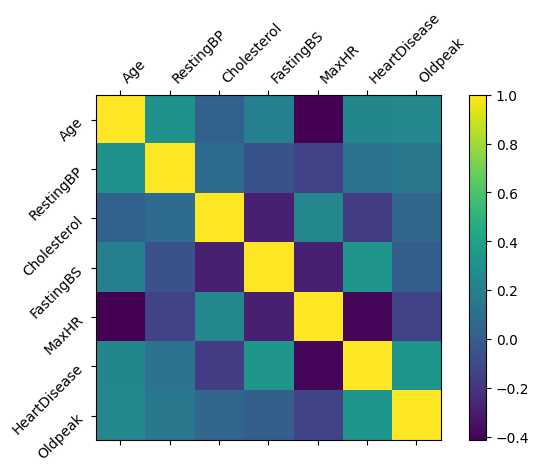

                   Age  RestingBP  Cholesterol  FastingBS     MaxHR  \
Age           1.000000   0.312539     0.021878   0.192591 -0.415929   
RestingBP     0.312539   1.000000     0.079769  -0.063615 -0.128857   
Cholesterol   0.021878   0.079769     1.000000  -0.290812  0.238838   
FastingBS     0.192591  -0.063615    -0.290812   1.000000 -0.293670   
MaxHR        -0.415929  -0.128857     0.238838  -0.293670  1.000000   
HeartDisease  0.232927   0.125947    -0.156417   0.321986 -0.395992   
Oldpeak       0.241820   0.153488     0.049526   0.014734 -0.124249   

              HeartDisease   Oldpeak  
Age               0.232927  0.241820  
RestingBP         0.125947  0.153488  
Cholesterol      -0.156417  0.049526  
FastingBS         0.321986  0.014734  
MaxHR            -0.395992 -0.124249  
HeartDisease      1.000000  0.327148  
Oldpeak           0.327148  1.000000  


In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(df_numerical.corr())
fig.colorbar(cax)
ax.set_xticklabels(['']+columns, rotation = 45, ha="left")
ax.set_yticklabels(['']+columns, rotation = 45, ha="right")
plt.tight_layout()
plt.savefig('export/numerical_correlations.pdf')
plt.show()
print(df_numerical.corr())

### Correlation matrix including categorical features

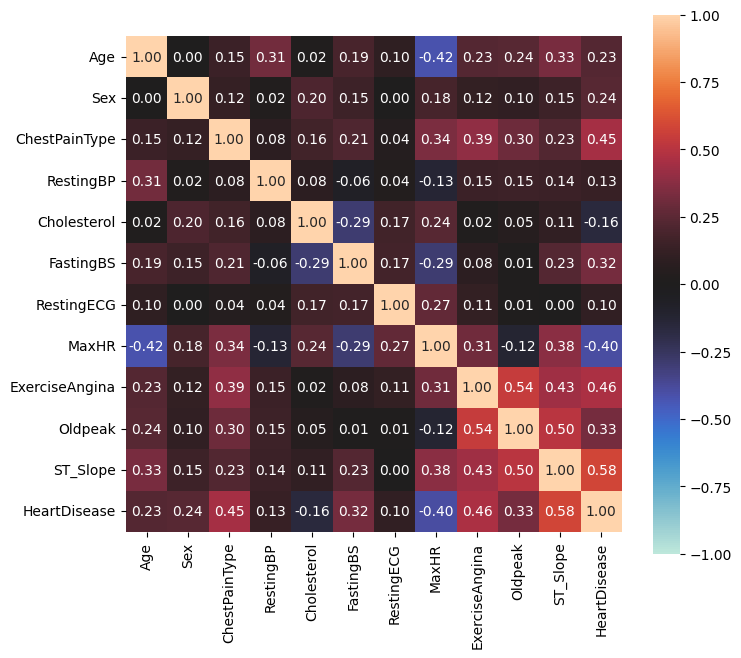

In [10]:
from dython.nominal import associations

from dython.nominal import identify_nominal_columns
categorical_features=identify_nominal_columns(df)
categorical_features

fig=plt.figure(figsize=(8, 7))
associations(
    df,
    ax=fig.gca(),
    nominal_columns='auto',
    numerical_columns=None,
    mark_columns=False,
    nom_nom_assoc='cramer',
    num_num_assoc='pearson',
    cramers_v_bias_correction=True,
    nan_strategy='drop_sample_pairs',
    annot=True, fmt='.2f',
    cmap=None, sv_color='silver', cbar=True, vmax=1.0, vmin=None,
    clustering=False, title=None)
fig.tight_layout()
fig.savefig('export/all_correlations.pdf')


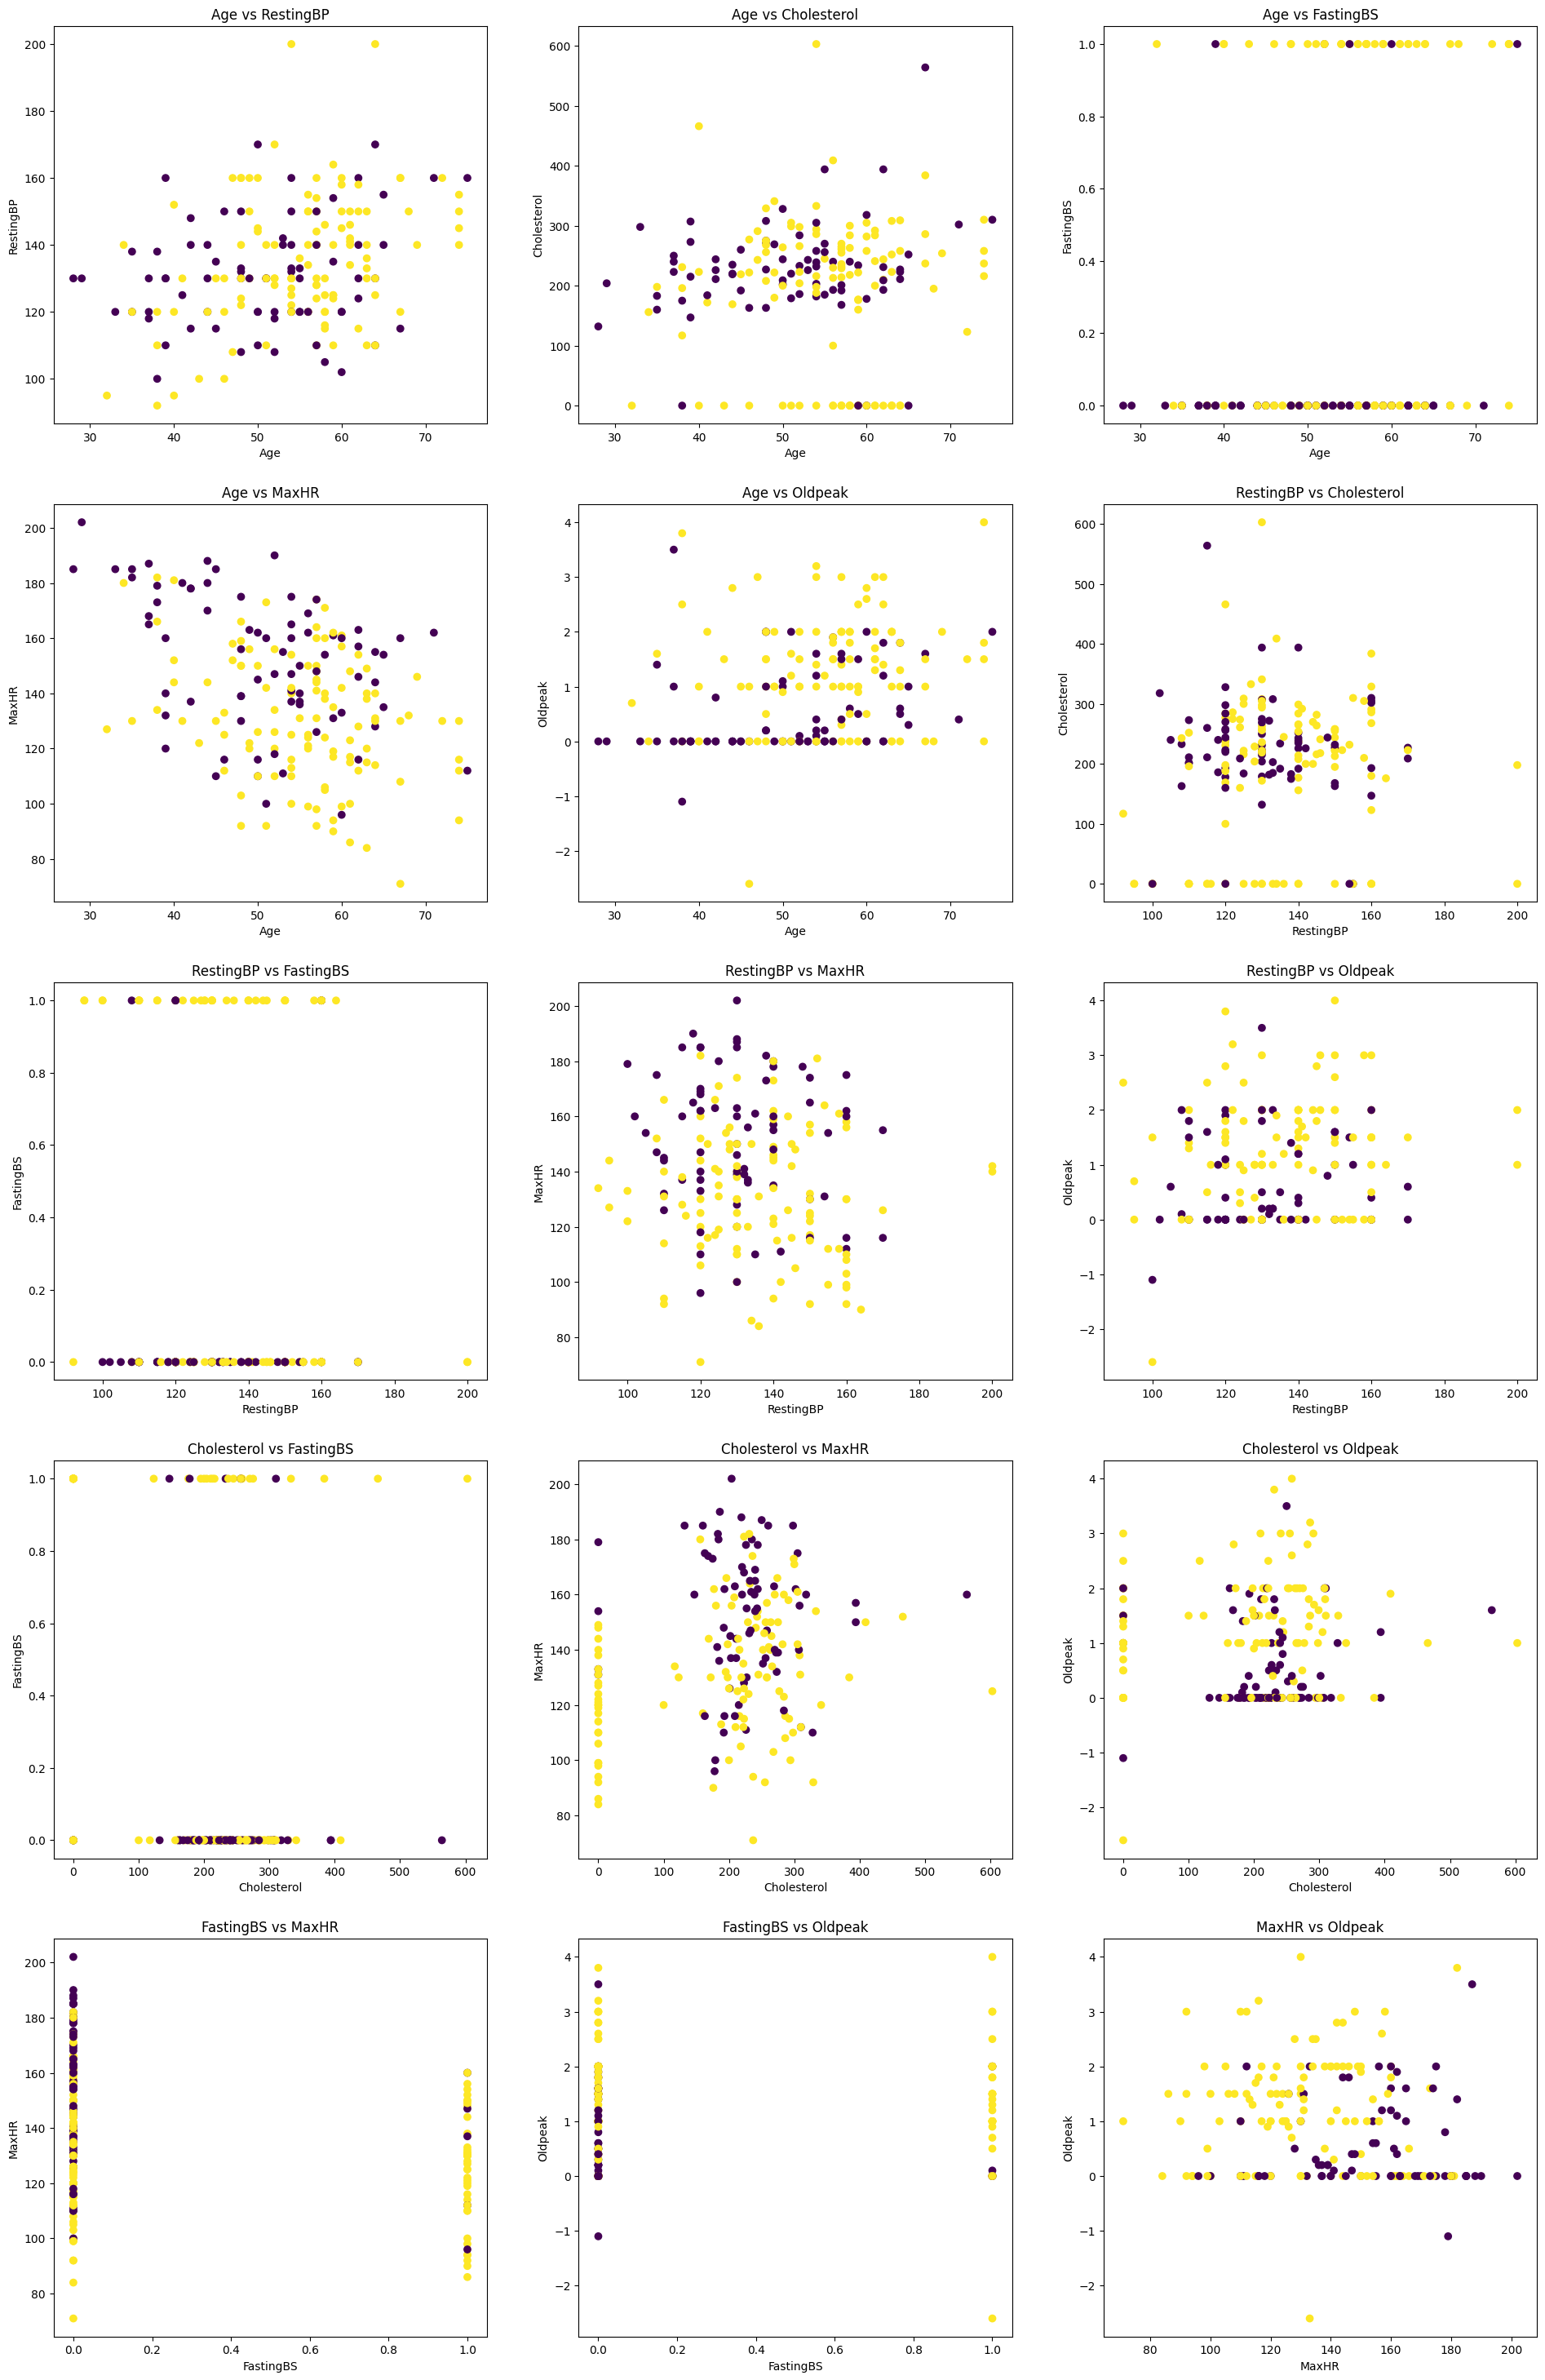

In [11]:
columns = df.select_dtypes(include=[float, int]).columns
col_comb = [(i, j) for cnt, i in enumerate(columns) for j in columns[cnt:] if i != j and i != 'HeartDisease' and j != 'HeartDisease']
fig, axs = plt.subplots(5,3, figsize=(20,30))
fig.tight_layout(pad=5.0)
for cnt, (x, y) in enumerate(col_comb):
    axs[cnt//3, cnt%3].scatter(df[x], df[y], c=df['HeartDisease'])
    axs[cnt//3, cnt%3].set_xlabel(x)
    axs[cnt//3, cnt%3].set_ylabel(y)
    axs[cnt//3, cnt%3].set_title(x + ' vs ' + y)
plt.show()
plt.close()

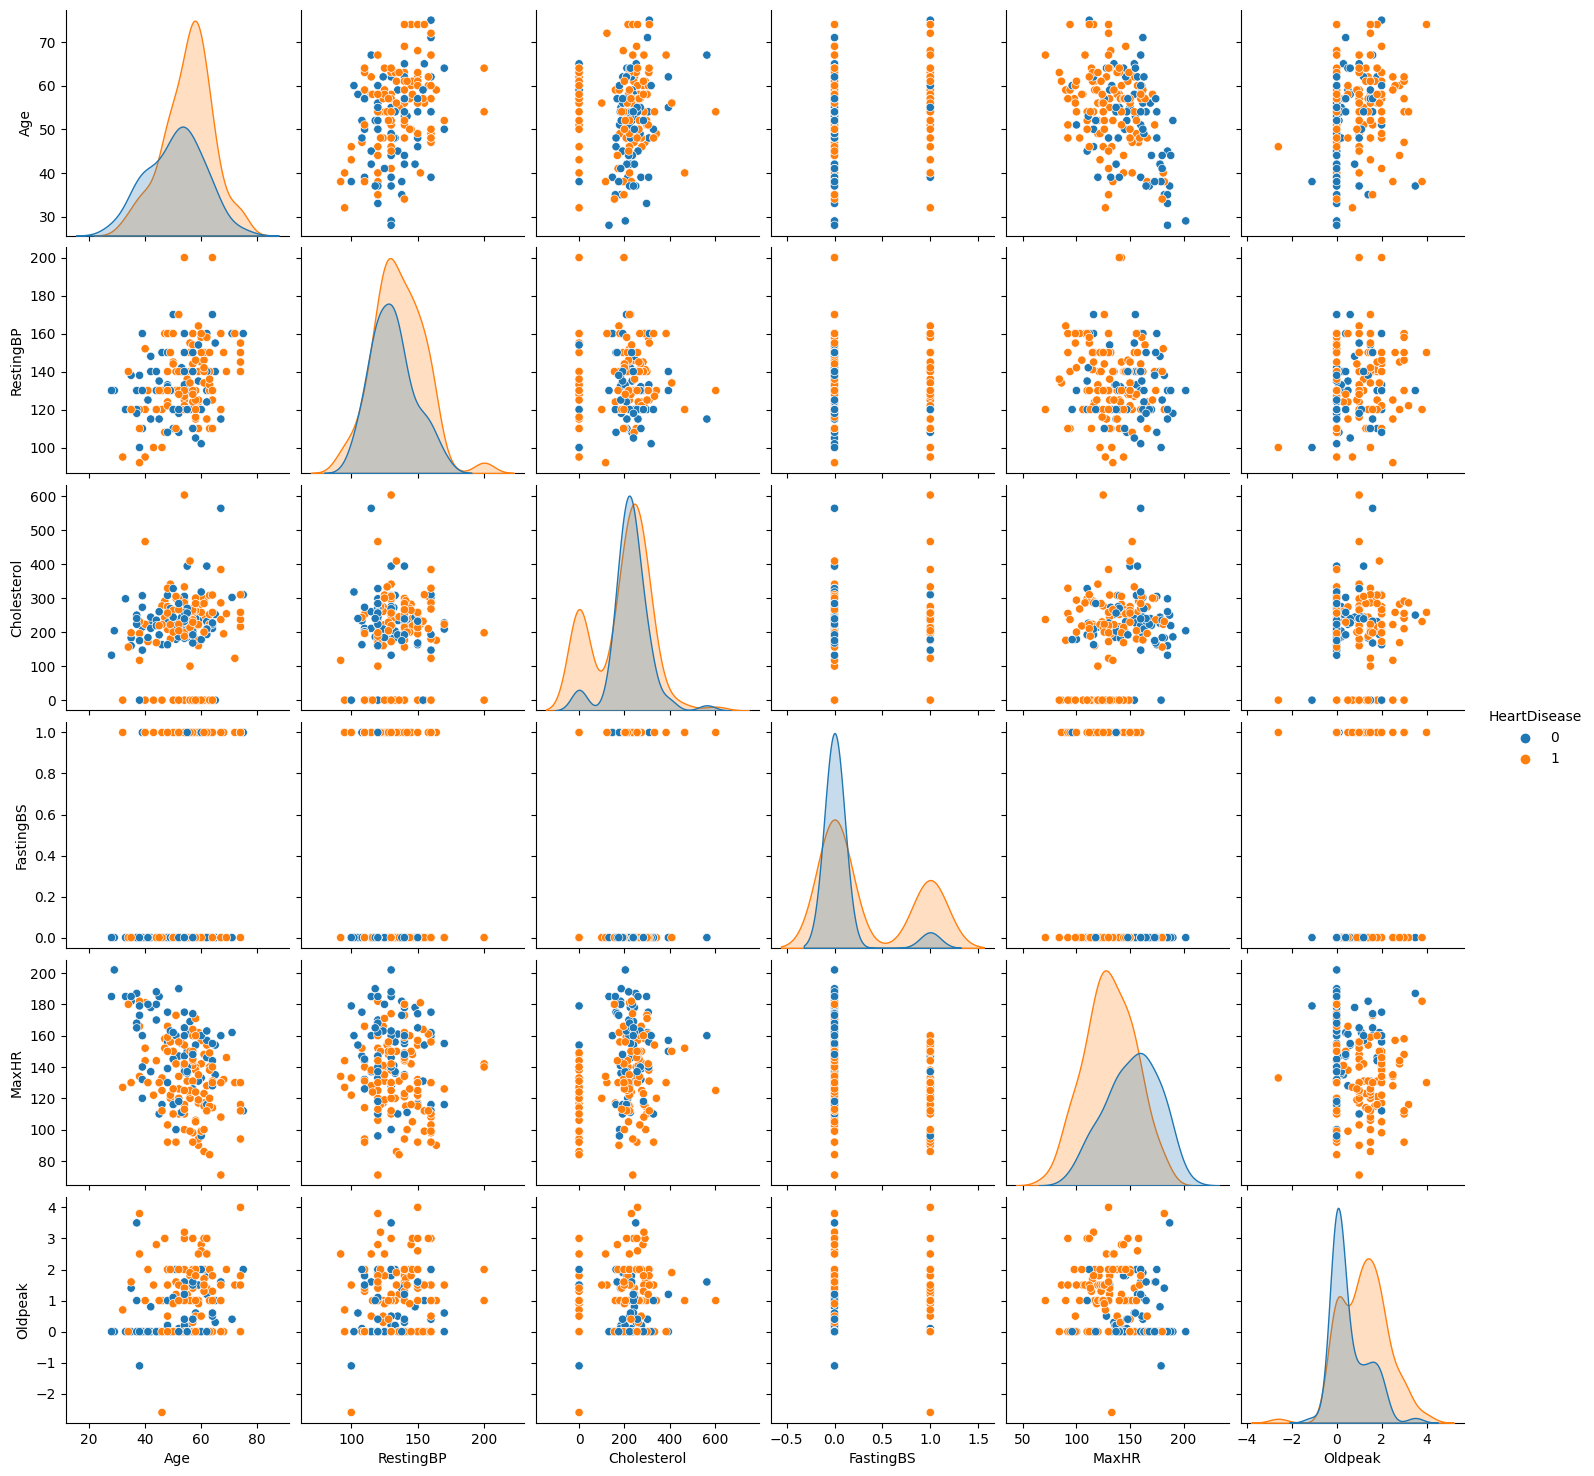

In [12]:
sns.pairplot(df, hue='HeartDisease')
plt.savefig('export/pairplot.pdf')
plt.show()

Based on the correlation matrix, the most relevant features for Heart Disease prediction are:

- ST_Slope

- ExerciseAngina

- ChestPainType

- MaxHR

## Preprocessing for training

- replace categorical features with one-hot vectors

- replace ST_Slope with values -1, 0, 1 to better capture the nature of the data

In [13]:
np.set_printoptions(suppress=True, threshold=100000)

### Split into train/test datasest

In [14]:
train_data, test_data = train_test_split(df, random_state=0)
print(f"Train size: {len(train_data)}")
print(f"Test size:  {len(test_data)}")

Train size: 138
Test size:  46


### Data pipeline

In [15]:
def ST_Slope_to_float(df):
    return df.replace(
        {
            "Down": -1,
            "Flat": 0,
            "Up": 1,
        }
    )

numerical_columns = ["Age", "RestingBP", "Cholesterol", "FastingBS", "MaxHR", "Oldpeak"]
numerical_transformer = Pipeline(steps=[
    ("imputer", KNNImputer(n_neighbors=2, weights="uniform")),
    ("scaler", StandardScaler()),
])

categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina']
categorical_transformer = Pipeline(steps=[
   ('onehot', OneHotEncoder(sparse_output=False, drop='if_binary')),
   ("scaler", StandardScaler()),
])

preprocessor = ColumnTransformer(verbose_feature_names_out=False,transformers=[
    ('numerical', numerical_transformer, numerical_columns),
    ('categorical', categorical_transformer, categorical_columns),
    ('st_slope', Pipeline(steps=[
        ('st_slope', FunctionTransformer(ST_Slope_to_float, validate=False, feature_names_out='one-to-one')),
        ("scaler", StandardScaler()),
    ]), ['ST_Slope']),
])
preprocessor.set_output(transform="pandas")

sklearn.set_config(display="diagram")
preprocessor

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('imputer',
                                                  KNNImputer(n_neighbors=2)),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'RestingBP', 'Cholesterol',
                                  'FastingBS', 'MaxHR', 'Oldpeak']),
                                ('categorical',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False)),
                                                 ('scaler', StandardScaler())]),
                                 ['Sex', 'ChestPainType', 'RestingECG',
                                  'ExerciseAngina']),
                                ('st_slope',
                                 Pipeline(steps=[('st_slope',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function ST_Slope_to_float at 0x7feaf9fdf5e0>)),
                                                 ('scaler', StandardScaler())]),
                                 ['ST_Slope'])],
                  verbose_feature_names_out=False)

In [16]:
# Fit the preprocessor to learn available feature names
transformed = preprocessor.fit_transform(train_data)
feature_names_out = [f.split("__")[-1] for f in preprocessor.get_feature_names_out()]
print(f"New feature names ({len(feature_names_out)}): "+", ".join(feature_names_out))
assert(len(feature_names_out) == transformed.shape[1])
transformed_df = pd.DataFrame(transformed, columns = feature_names_out)

print("StDevs: ")
display(transformed_df.std(axis=0))
print("Sample: ")
display(transformed_df.sample(1))

New feature names (16): Age, RestingBP, Cholesterol, FastingBS, MaxHR, Oldpeak, Sex_M, ChestPainType_ASY, ChestPainType_ATA, ChestPainType_NAP, ChestPainType_TA, RestingECG_LVH, RestingECG_Normal, RestingECG_ST, ExerciseAngina_Y, ST_Slope
StDevs: 


Age                  1.003643
RestingBP            1.003643
Cholesterol          1.003643
FastingBS            1.003643
MaxHR                1.003643
Oldpeak              1.003643
Sex_M                1.003643
ChestPainType_ASY    1.003643
ChestPainType_ATA    1.003643
ChestPainType_NAP    1.003643
ChestPainType_TA     1.003643
RestingECG_LVH       1.003643
RestingECG_Normal    1.003643
RestingECG_ST        1.003643
ExerciseAngina_Y     1.003643
ST_Slope             1.003643
dtype: float64

Sample: 


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope
67,-0.943878,-1.021711,0.505578,-0.582929,1.801664,-1.027908,0.423659,0.741999,-0.349215,-0.47036,-0.264135,1.897367,-1.347712,-0.39958,-0.877058,1.158297


### UMAP

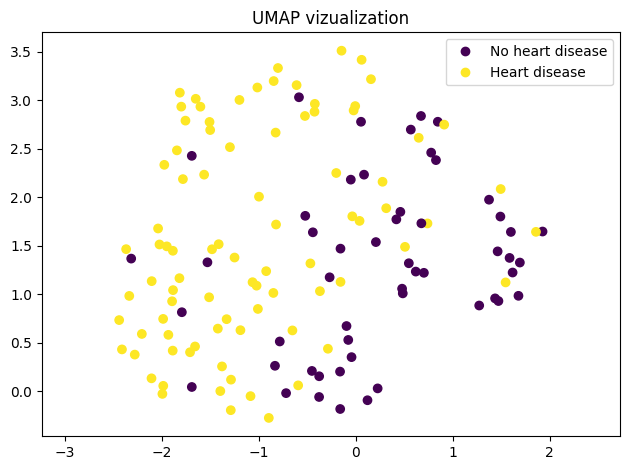

In [17]:
reducer = umap.UMAP(random_state=1, n_neighbors=100, min_dist=0.01)
embedding = reducer.fit_transform(preprocessor.transform(train_data))

scatter = plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=train_data['HeartDisease'],
)
plt.gca().set_aspect('equal', 'datalim')
plt.legend(handles=scatter.legend_elements()[0], labels=["No heart disease", "Heart disease"])
plt.title("UMAP vizualization")
plt.tight_layout()
plt.savefig('export/umap.pdf')
plt.show()

## Q2: Lasso regression

An important preprocessing step for Lasso regression (i.e. Logistic regression with the L1 regularization) is the standardization of the features (part of preprocessor )

In [18]:
alphas = np.logspace(-3, 0, 31)

# We use SGDClassifier (outputting a binary class) instead of Lasso (outputting a float)
# to be able to measure the F1 score directly
lasso = SGDClassifier(loss='log_loss', penalty='l1', random_state=0)

pipeline = Pipeline([
    ('features', preprocessor),
    ('regression', lasso)
])

grid_search = GridSearchCV(
    estimator = pipeline,
    param_grid = {'regression__alpha': alphas},
    scoring = 'f1',
    error_score='raise'
)

model = grid_search.fit(train_data, train_data['HeartDisease'])
best_alpha = grid_search.best_params_['regression__alpha']
best_alpha_coefs = grid_search.best_estimator_.named_steps['regression'].coef_

print('Train F1: ' + str(model.score(train_data, train_data['HeartDisease'])))
print('Test  F1: ' + str(model.score(test_data, test_data['HeartDisease'])))

Train F1: 0.8554913294797688
Test  F1: 0.7916666666666666


### Feature coefficients for different values of $\alpha$ 

In [19]:
coefs = []
for a in np.flip(alphas):
    pipeline.set_params(regression__alpha = a)
    pipeline.fit(train_data, train_data['HeartDisease'])
    coefs.append(lasso.coef_[0])
coefs = np.transpose(np.array(coefs))

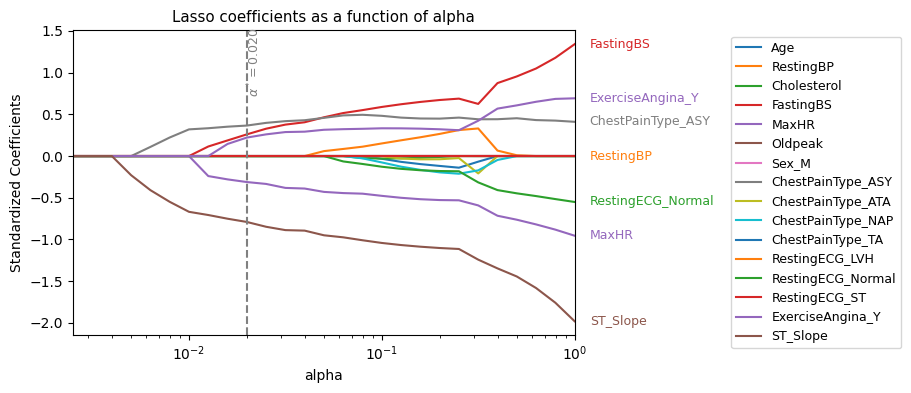

In [20]:
import matplotx

plt.figure(figsize=(10,4))
ax = plt.gca()
for coef, feature_name in zip(coefs, feature_names_out):
    display_feature_label = np.any(np.abs(coef) > 0.3)
    ax.plot(
        alphas, coef,
        **({"label": feature_name} if display_feature_label else {}))
    
ax.set_xscale('log')
plt.axis('tight')
plt.xlim(2.5e-3, 1)
plt.xlabel('alpha')

plt.rc('font', size=9)
plt.rc('legend', fontsize=9)    
plt.legend(labels = feature_names_out, loc='upper left', bbox_to_anchor=(1.3, 1))
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha')

matplotx.line_labels()

plt.axvline(best_alpha, linestyle="--", color="grey")
x_bounds = ax.get_xlim()
ax.annotate(text=f"$\\alpha^* = {best_alpha:.3f}$", xy =(0.36,1.01), xycoords='axes fraction', verticalalignment='top', horizontalalignment='center' , rotation = 90, color="grey")

plt.tight_layout()
plt.savefig('export/lasso_coef_f.pdf')
plt.show()


We notice that the features highly correlated with HeartDisease are very similar to those marked as most relevant by the Lasso regression:

- ST_Slope

- ChestPainType_ASY

- MaxHR

- FastingBS

### Lasso regression with filtered features

In [21]:
# Fit the previous model again with best_alpha to select all features with coefficient > 0
pipeline.set_params(regression__alpha = best_alpha)
model = pipeline.fit(train_data, train_data['HeartDisease'])

np.where(np.abs(model.named_steps.regression.coef_[0]) > 0)

(array([ 1,  3,  4,  7, 14, 15]),)

In [22]:
feature_selector = SelectFromModel(pipeline, prefit=True, threshold=1e-5, importance_getter='named_steps.regression.coef_')

lasso_filtered_features = SGDClassifier(loss='log_loss', penalty='l1', random_state=0)
pipeline_filtered_features = Pipeline([
    ('features', preprocessor),
    ('feature_selection', ColumnTransformer([
        ('passthrough', 'passthrough', np.where(np.abs(model.named_steps.regression.coef_[0]) > 0)[0])
    ])),
    ('regression', lasso_filtered_features)
])

grid_search_filtered_features = GridSearchCV(
    estimator = pipeline_filtered_features,
    param_grid = {'regression__alpha': alphas},
    scoring = 'f1',
    error_score='raise'
)

model_filtered_features = grid_search_filtered_features.fit(train_data, train_data['HeartDisease'])
best_alpha_filtered_features = grid_search.best_params_['regression__alpha']
best_alpha_coefs_filtered_features = grid_search.best_estimator_.named_steps['regression'].coef_

print('Train F1: ' + str(model_filtered_features.score(train_data, train_data['HeartDisease'])))
print('Test  F1: ' + str(model_filtered_features.score(test_data, test_data['HeartDisease'])))
print(f"best_alpha: {best_alpha:.2f}, best_alpha_filtered_features: {best_alpha_filtered_features:.2f}")

Train F1: 0.8554913294797688
Test  F1: 0.7916666666666666
best_alpha: 0.02, best_alpha_filtered_features: 0.02


Fitting a logistic regression using only the important variables results in a lower score during training. However, as demonstrated, the reduced dimensionality of the input features helps the model to generalise to new data, and thus it's better to keep only the important features.

In the experiment above, we used the 5 features with non-zero coefficients at alpha=0.03.

## Q3: Decision Trees

### DecisionTree

In [23]:
from sklearn.tree import DecisionTreeClassifier

pipeline = Pipeline([
    ('features', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=0, max_depth=3))
])

model = pipeline.fit(train_data, train_data['HeartDisease'])

print('Train F1: ' + str(model.score(train_data, train_data['HeartDisease'])))
print('Test  F1: ' + str(model.score(test_data, test_data['HeartDisease'])))

Train F1: 0.8768115942028986
Test  F1: 0.8043478260869565


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
/root/venv/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


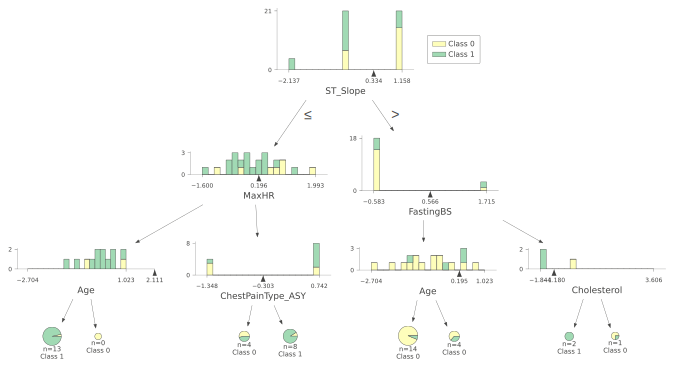

In [24]:
import dtreeviz
dtreeviz_model = dtreeviz.model(
    pipeline.named_steps.classifier,
    preprocessor.transform(test_data), test_data['HeartDisease'],
    feature_names = feature_names_out
)
v = dtreeviz_model.view()
v.save('export/decision_tree.svg')

from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF
drawing = svg2rlg("export/decision_tree.svg")
renderPDF.drawToFile(drawing, "export/decision_tree.pdf")

v

### RandomForest

In [25]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('features', preprocessor),
    ('classifier', RandomForestClassifier(random_state=0))
])

model = pipeline.fit(train_data, train_data['HeartDisease'])

print('Train F1: ' + str(model.score(train_data, train_data['HeartDisease'])))
print('Test  F1: ' + str(model.score(test_data, test_data['HeartDisease'])))

Train F1: 1.0
Test  F1: 0.8043478260869565


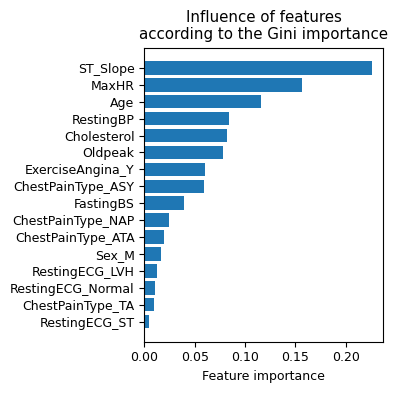

In [26]:
sorted_feature_indices = np.argsort(model.named_steps.classifier.feature_importances_)
plt.figure(figsize=(4,4))
plt.barh(
    np.array(feature_names_out)[sorted_feature_indices],
    model.named_steps.classifier.feature_importances_[sorted_feature_indices]
)
plt.title("Influence of features\naccording to the Gini importance")
plt.xlabel("Feature importance");
plt.tight_layout()
plt.savefig('export/random_forest.pdf')

## Q4: Multi-Layer Perceptrons

In [27]:
from sklearn.neural_network import MLPClassifier

pipeline = Pipeline([
    ('features', preprocessor),
    ('classifier', MLPClassifier(
        hidden_layer_sizes=(32, 32),
        activation='relu',
        solver='adam',
        alpha=0.0001,
        max_iter=200,
        shuffle=True,
        random_state=0,
    ))
])

grid_search = GridSearchCV(
    estimator = pipeline,
    param_grid = {f'classifier__{k}': v for k, v in {
        'hidden_layer_sizes': [(8, ), (12,), (16,), (20,), (32,), (16, 16), ],
        'alpha': np.logspace(-1, 1, 5),
        'max_iter': [2000, 4000, 8000],
        'learning_rate_init': [0.0001, 0.001],
    }.items()},
    scoring = 'f1',
    error_score='raise',
)

In [28]:
%%script false --no-raise-error

# train the MLP
model = grid_search.fit(train_data, train_data['HeartDisease'])

print('Train F1: ' + str(model.score(train_data, train_data['HeartDisease'])))
print('Test  F1: ' + str(model.score(test_data, test_data['HeartDisease'])))

grid_search.best_params_

In [29]:
from sklearn.neural_network import MLPClassifier

pipeline = Pipeline([
    ('features', preprocessor),
    ('classifier', MLPClassifier(
        hidden_layer_sizes=(26,),
        activation='relu',
        solver='adam',
        alpha=0.3162, # found using GridSearch above
        max_iter=2000,
        learning_rate_init=0.0001,
        shuffle=True,
        random_state=0,
    ))
])

# train the MLP
model = pipeline.fit(train_data, train_data['HeartDisease'])

print('Train F1: ' + str(model.score(train_data, train_data['HeartDisease'])))
print('Test  F1: ' + str(model.score(test_data, test_data['HeartDisease'])))

Train F1: 0.8985507246376812
Test  F1: 0.8043478260869565


In [30]:
# From https://datascience.stackexchange.com/a/45166

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = tf.cast(true_positives, tf.float32) / (tf.cast(possible_positives, tf.float32) + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = tf.cast(true_positives, tf.float32) / (tf.cast(predicted_positives, tf.float32) + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


2023-04-18 16:41:37.334741: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-18 16:41:37.334774: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-18 16:41:37.334790: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-8e4db396-18e9-4489-b011-ba508fea49e1): /proc/driver/nvidia/version does not exist
2023-04-18 16:41:37.335014: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Train F1: 0.8953488372093024
Test  F1: 0.8
Test  F1m: 0.79999995

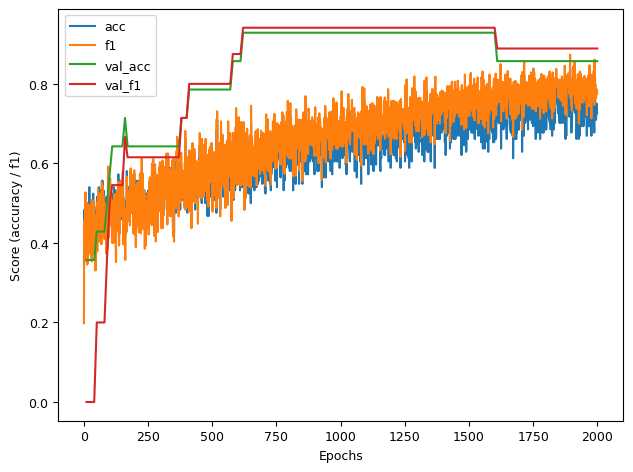

In [31]:
# MLP with Dropout
import keras
from keras import layers
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from sklearn.metrics import f1_score

def f1_score_tensors(y_true, y_pred):
    return f1_score(y_true.numpy(), (y_pred.numpy()>0.5).astype(int))

def build_model():
    inputs = keras.Input(shape=16)
    x = inputs
    x = layers.Dense(26, activation="relu")(x)
    #x = layers.Dense(20, activation="relu")(x)
    x = layers.Dropout(0.8, seed=0)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(
            learning_rate=0.0001,
        ),
        loss=BinaryCrossentropy(),
        metrics=['accuracy', f1_m]
    )
    return model

# train the MLP
keras.utils.set_random_seed(0)
classifier = build_model()
validation_freq = 10
history = classifier.fit(
    preprocessor.transform(train_data), train_data['HeartDisease'],
    validation_split=0.1,
    batch_size=184, epochs=2000, verbose=0, validation_freq=validation_freq)

def predict_binary(classifier, x):
    return (classifier.predict(preprocessor.transform(x), verbose=0)>0.5).astype(int).reshape((-1,))

print('Train F1: ' + str(f1_score(train_data['HeartDisease'], predict_binary(classifier, train_data))))
print('Test  F1: ' + str(f1_score(test_data['HeartDisease'], predict_binary(classifier, test_data))))
print('Test  F1m: ' + str(f1_m(test_data['HeartDisease'], predict_binary(classifier, test_data)).numpy()))

validation_x = np.arange(1,1+len(history.history['val_accuracy'])) * validation_freq
plt.plot(history.history['accuracy'], label="acc")
plt.plot(history.history['f1_m'], label="f1")
plt.plot(validation_x, history.history['val_accuracy'], label="val_acc")
plt.plot(validation_x, history.history['val_f1_m'], label="val_f1")
plt.plot()
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Score (accuracy / f1)")
plt.tight_layout()
plt.savefig("export/mlp_training.pdf")
plt.show()

In [32]:
# Train once again on the whole training dataset
classifier.fit(
    preprocessor.transform(train_data), train_data['HeartDisease'],
    batch_size=184, epochs=2000, verbose=0);
print('Train F1: ' + str(f1_score(train_data['HeartDisease'], predict_binary(classifier, train_data))))
print('Test  F1: ' + str(f1_score(test_data['HeartDisease'], predict_binary(classifier, test_data))))

Train F1: 0.8953488372093024
Test  F1: 0.8


In [33]:
# Calculate SHAP values

explainer = shap.explainers.Exact(model.named_steps.classifier.predict, preprocessor.transform(train_data))
shap_values = explainer(preprocessor.transform(test_data))

Exact explainer: 47it [01:19,  1.88s/it]


Int64Index([60, 97, 61, 166], dtype='int64')


'No heart disease (1/4), index 60, ordinal index 4'

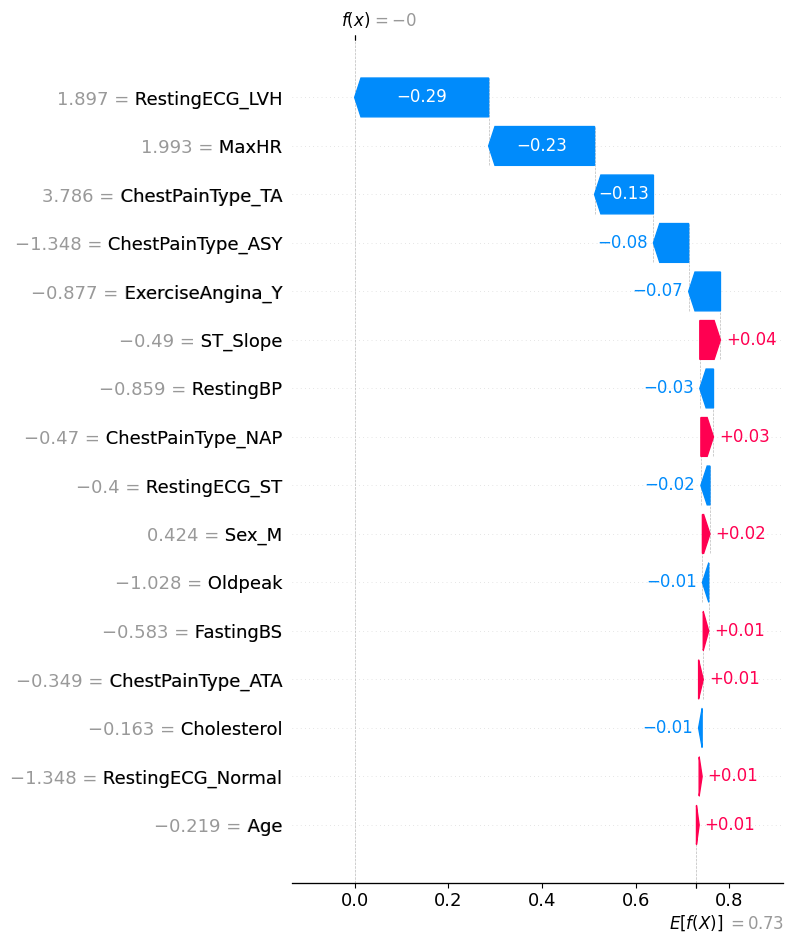

'No heart disease (2/4), index 97, ordinal index 5'

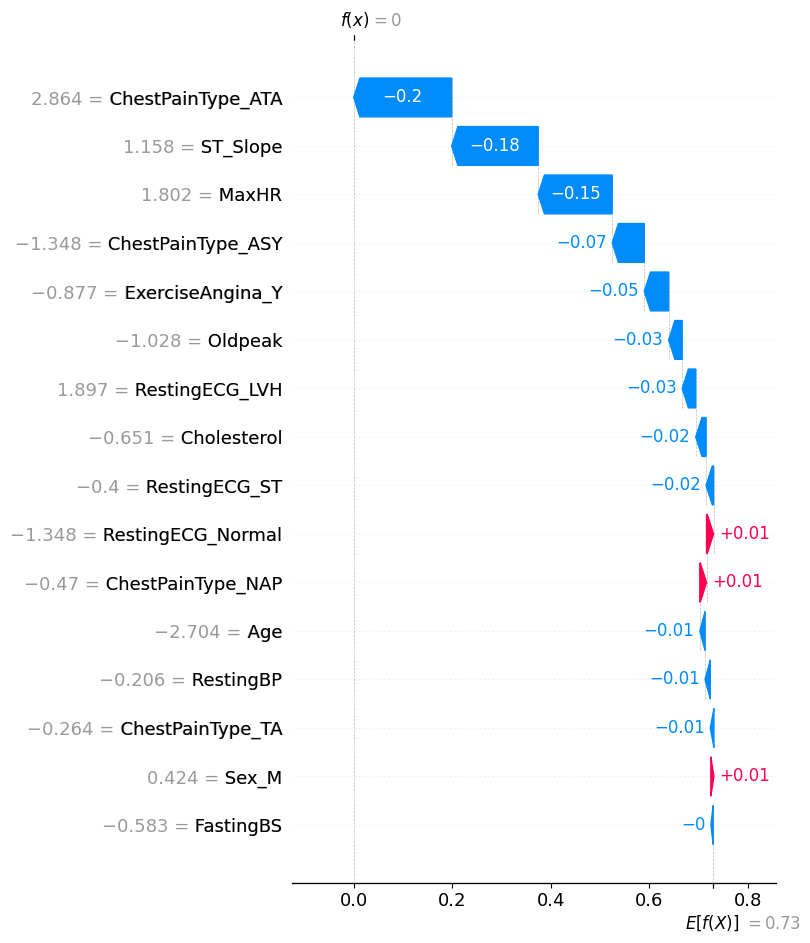

'No heart disease (3/4), index 61, ordinal index 6'

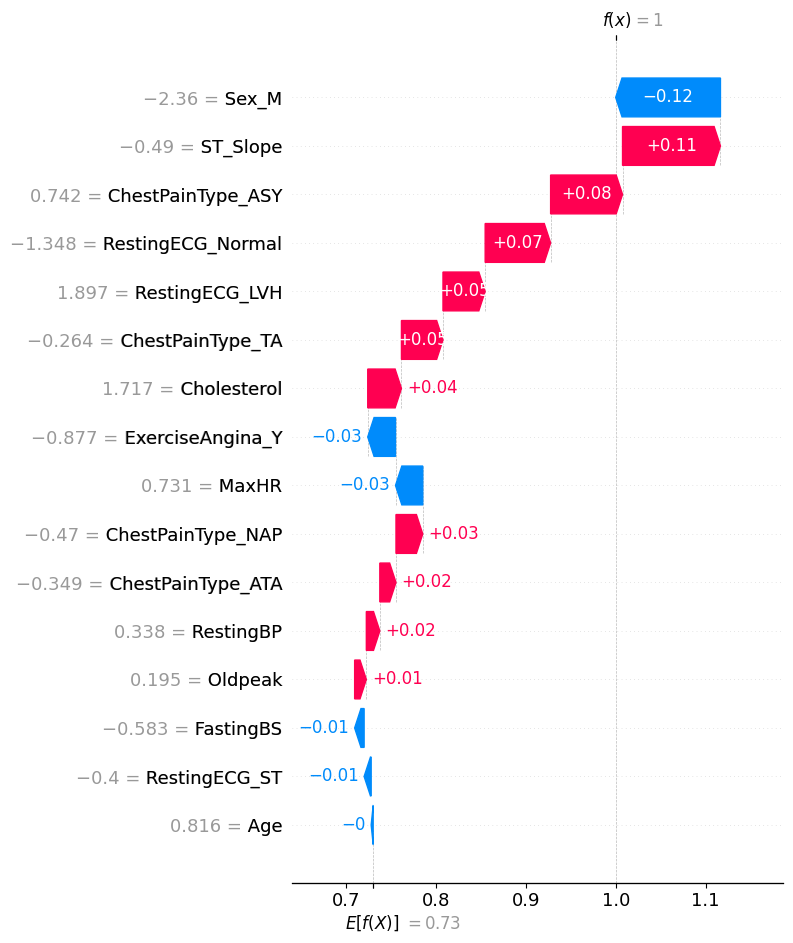

'No heart disease (4/4), index 166, ordinal index 7'

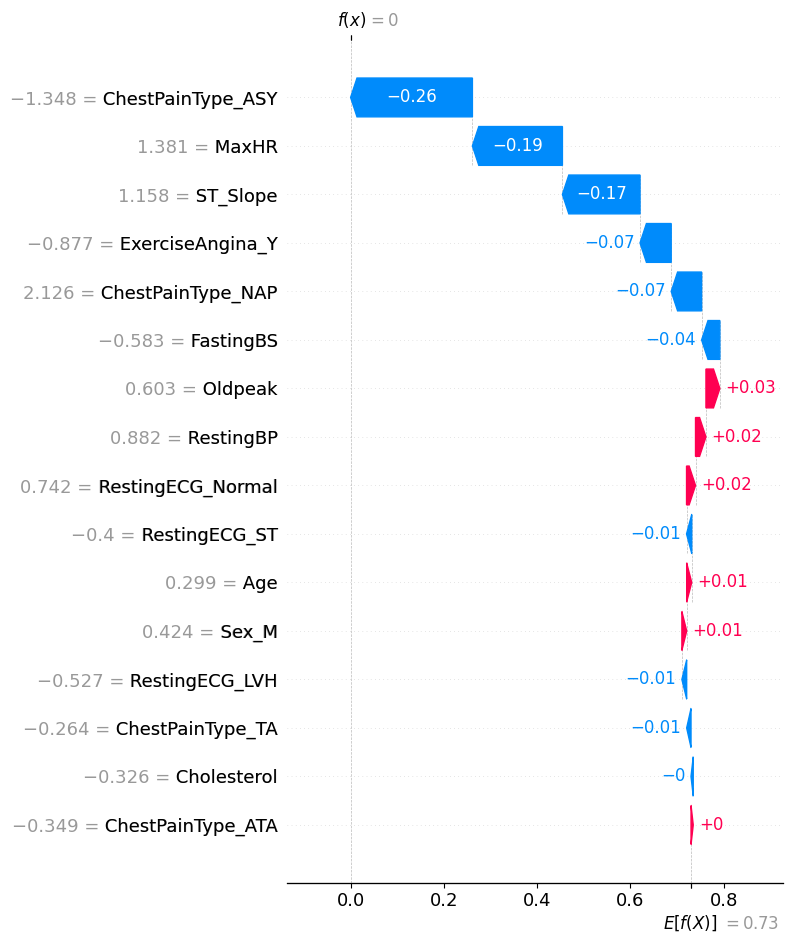

Int64Index([139, 106, 7, 107], dtype='int64')


'Heart disease (1/4), index 139, ordinal index 0'

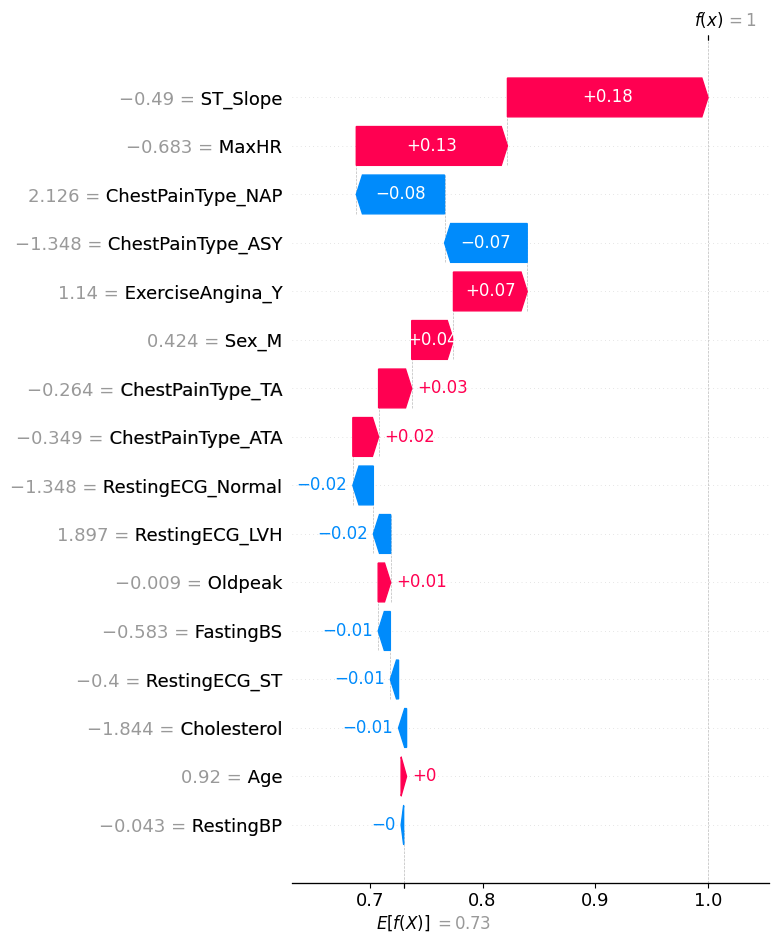

'Heart disease (2/4), index 106, ordinal index 1'

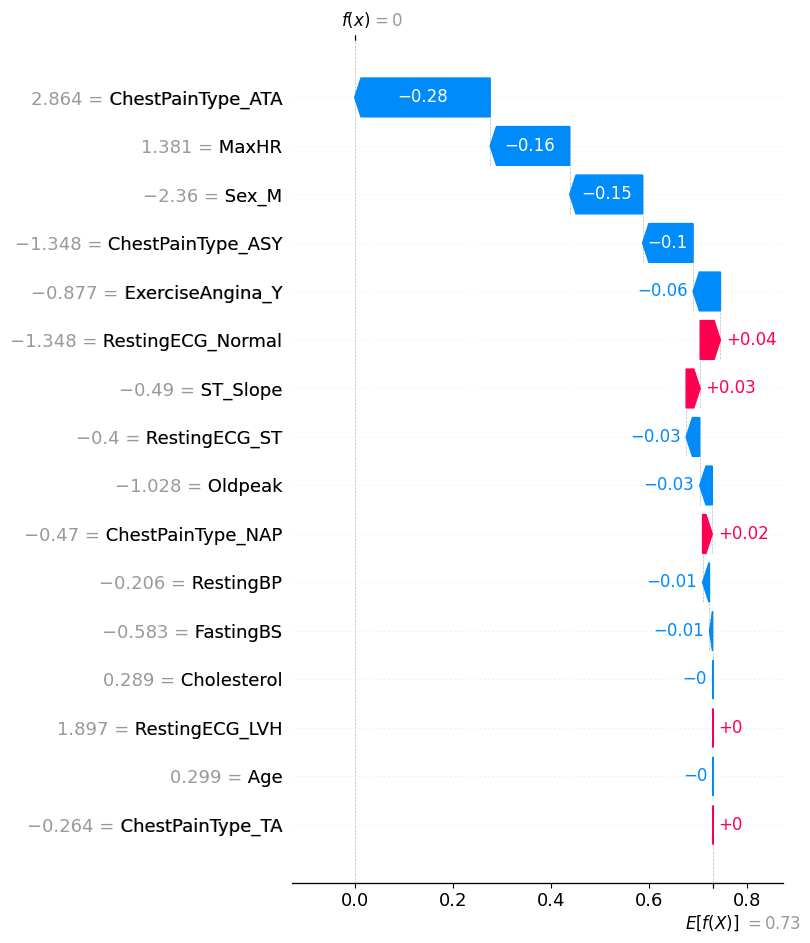

'Heart disease (3/4), index 7, ordinal index 2'

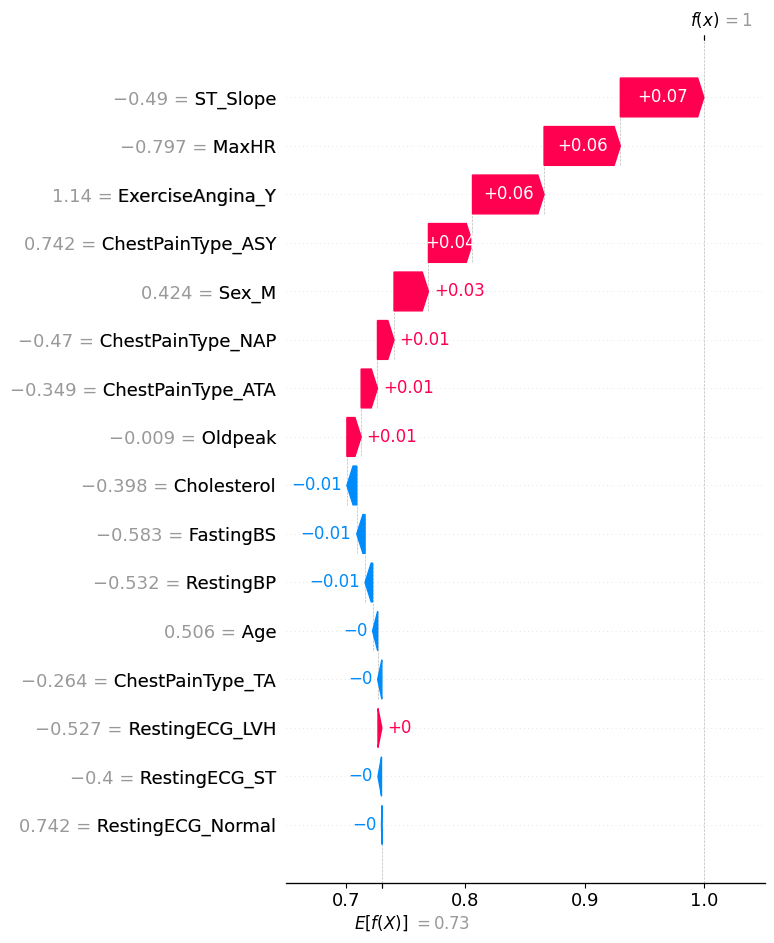

'Heart disease (4/4), index 107, ordinal index 3'

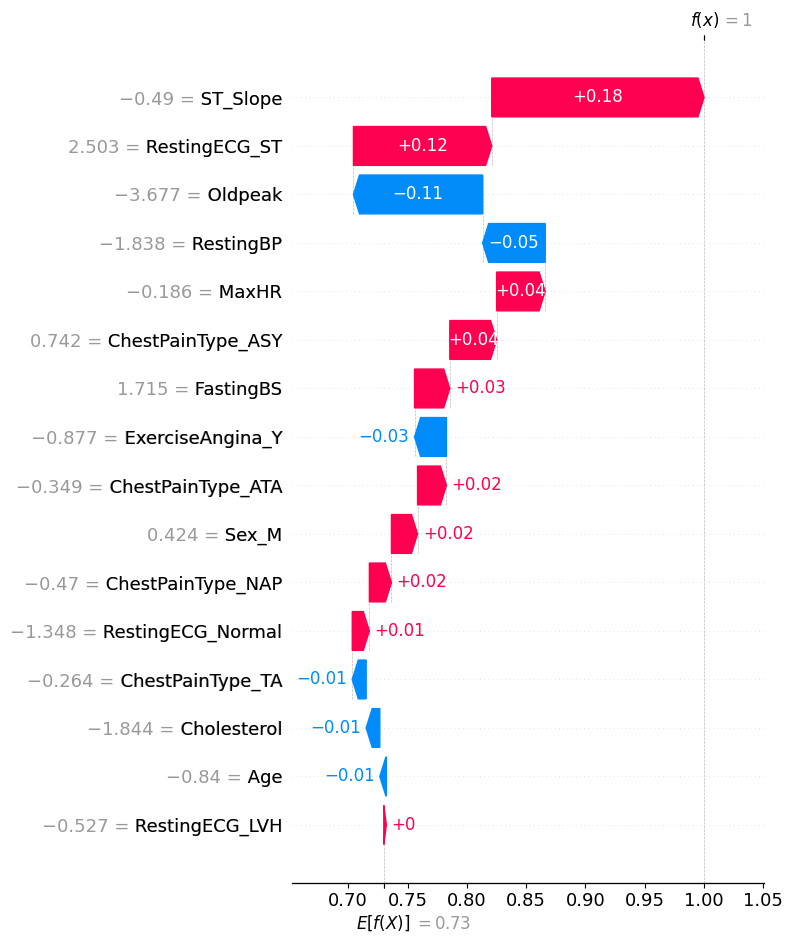

In [34]:
# Visualize SHAP explanations of the outputs of four positive and negative samples
for target_y, label in [(0, "No heart disease"), (1, "Heart disease")]:
    indices = test_data.index[test_data['HeartDisease'] == target_y][:4]
    print(indices)
    for i, index in enumerate(indices):
        # SHAP values don't use the pandas indices of test_data (which have permuted order),
        # so we need to calculate the ordinal index
        ordinal_index = np.where(test_data.index == index)[0][0]
        display(f"{label} ({i+1}/4), index {index}, ordinal index {ordinal_index}")
        shap.plots.waterfall(shap_values[ordinal_index], max_display=20, show=False)
        plt.tight_layout()
        plt.savefig(f"export/shap_sample_{'positive' if target_y else 'negative'}_{i+1}.pdf")
        plt.show()

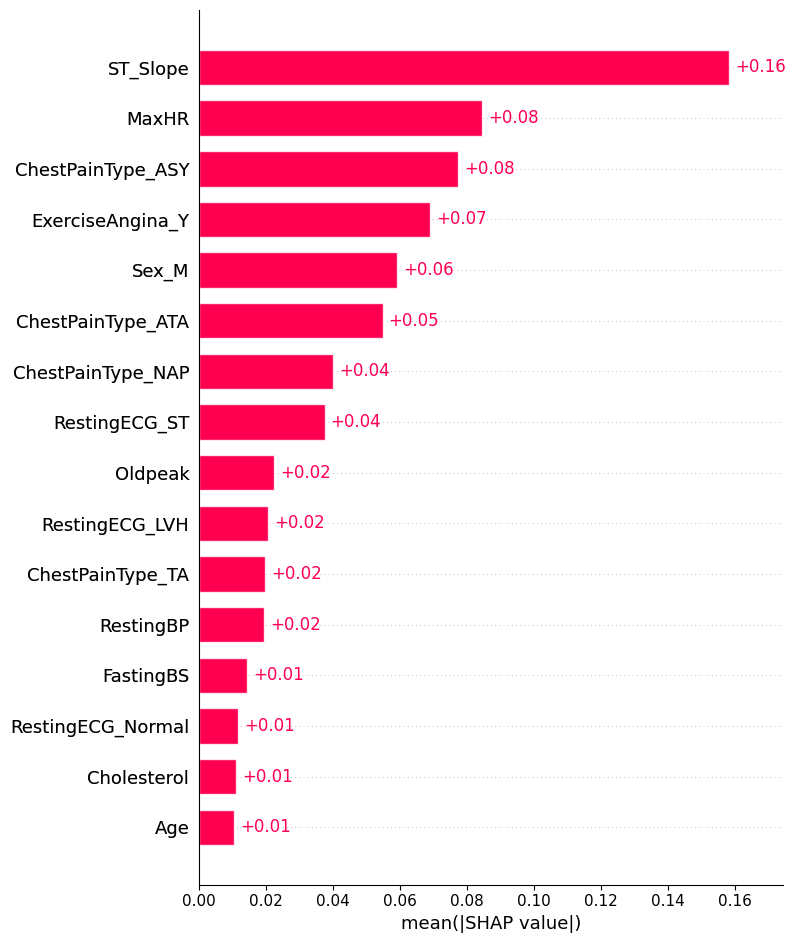

In [35]:
shap.plots.bar(shap_values, max_display=20, show=False)
plt.tight_layout()
plt.savefig('export/shap_bar.pdf')
plt.show()

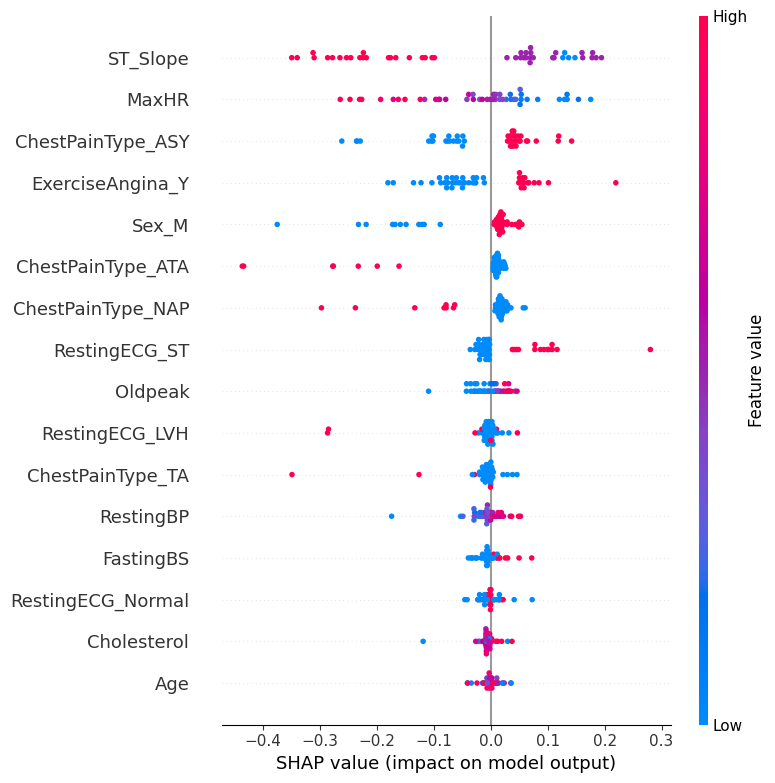

In [36]:
shap.plots.beeswarm(shap_values, max_display=20, show=False)
plt.tight_layout()
plt.savefig('export/shap_beeswarm.pdf')
plt.show()

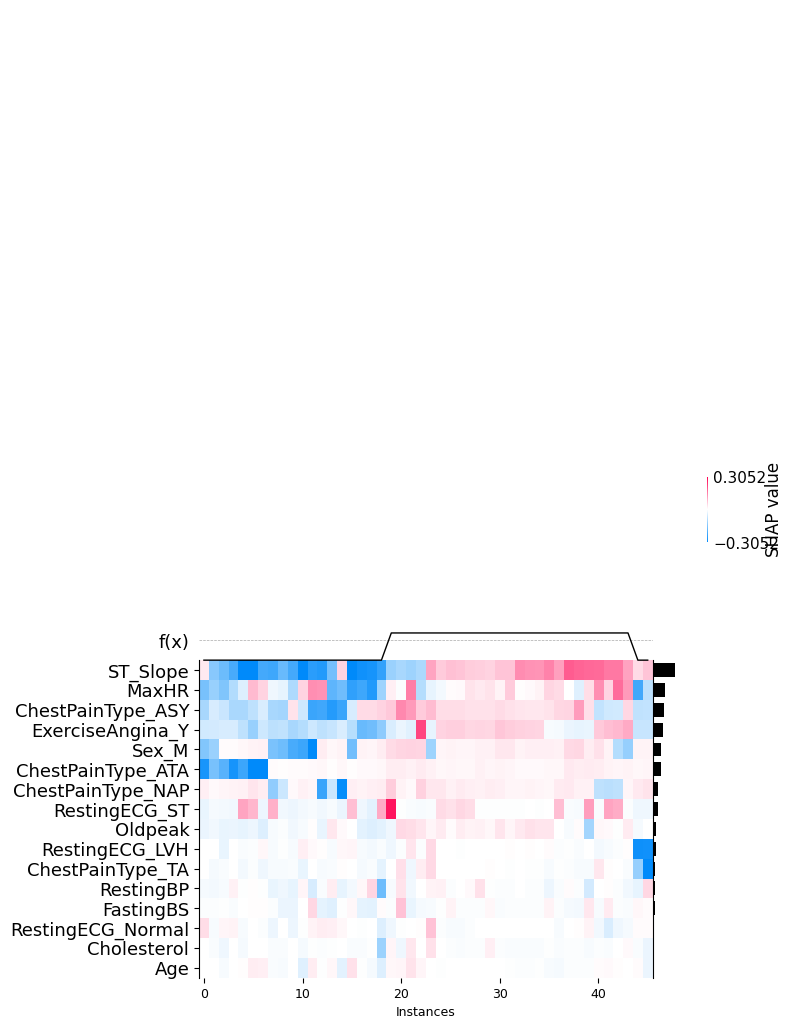

In [37]:
shap.plots.heatmap(shap_values, max_display=20, show=False)
plt.tight_layout()
plt.savefig("export/shap_heatmap.pdf")
plt.show()

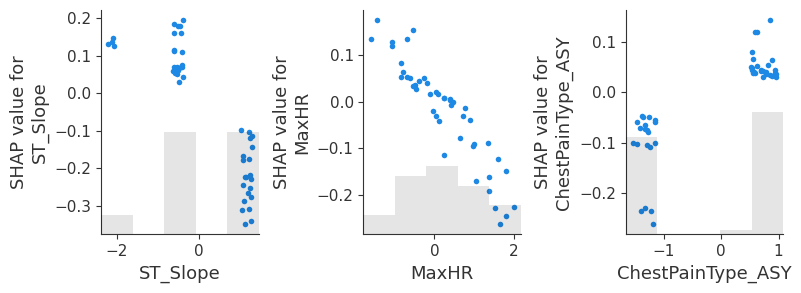

In [38]:
fig, axs = plt.subplots(1,3,figsize=(8,3))
shap.plots.scatter(shap_values[:, "ST_Slope"], ax=axs[0], show=False)
shap.plots.scatter(shap_values[:, "MaxHR"], ax=axs[1], show=False)
shap.plots.scatter(shap_values[:, "ChestPainType_ASY"], ax=axs[2], show=False)
plt.tight_layout()
plt.savefig('export/shap_scatter.pdf')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8e4db396-18e9-4489-b011-ba508fea49e1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>